<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification_early_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

# Table of Contents

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[Table of Contents](#scrollTo=4sAfyFF7dWGm)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Fetch cleaned dataset](#scrollTo=ALAyxPryCqFZ)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)

>>[Modalities experimentations](#scrollTo=t46qlhPe2vHq)

>>>[Raw](#scrollTo=9ZMbXtvfG7Sa)

>>>[Spectrogram](#scrollTo=BAQnayGxG9vz)

>>>[MFCC](#scrollTo=b5Vm59MxHBYF)

>[Preprocessing & Packaging](#scrollTo=vg4POlOg2W6W)

>>[Waveform](#scrollTo=4jVjfEH_58rV)

>>[Spectrogram](#scrollTo=sHgonxaM55bk)

>>[MFCC](#scrollTo=zgxrq6hy512E)

>>[Late fusion](#scrollTo=zHJDrkAhh522)

>>[Splitting Scheme](#scrollTo=9fs5X3NsPoZC)

>[Models](#scrollTo=PqSY1g2A2Yop)

>>[Pretrained](#scrollTo=mgXcolX4i9wc)

>>[SimpleNet](#scrollTo=2VMz6UQNvOzu)

>>[M5](#scrollTo=VBk4K9jdvRnQ)

>>[2d-CNN](#scrollTo=2bE-6QvuyNRH)

>[Training & Evaluation](#scrollTo=-b6VY1rH4Yrq)

>>[utils](#scrollTo=C47C65anl7y7)

>>[Dataset Creation](#scrollTo=yoOivocnTSUS)

>>[E2E : Training & Evaluation](#scrollTo=tJxMkoJA-Jt-)

>>[Late Fusion: Training & Evaluation](#scrollTo=i3H0iI0tshqr)

>>[Early Fusion : Training & Evaluation](#scrollTo=AgU0S5cWgpi9)

>[Results](#scrollTo=DsWDErTBXs3L)



same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [ ]:
!nvidia-smi

Fri Aug 12 14:03:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |   1242MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu113
0.12.0+cu113


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import random 
import os
from copy import deepcopy

In [ ]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from IPython.display import Audio, display
from typing import Dict,Any

In [ ]:
import librosa


In [ ]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(42)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from torchvision import datasets, models, transforms
import torchvision

In [ ]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: nprime. Use `wandb login --relogin` to force relogin


True

In [ ]:
# show current directory
!pwd

/content


# utils

In [ ]:
reshaper = torchvision.transforms.Resize((256,256))

In [ ]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)


def estimate_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('Approximated model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [ ]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Fetch cleaned dataset

In [ ]:
DATASET = "Data_chunked_5.zip"
DESCRIPTOR_FILE = "building_floor_recognition_chunked_5.csv"

In [ ]:
# delete data if already existing
!rm -r Data/
!rm {DESCRIPTOR_FILE}

# Data_chunked_{chunk_size}, building_floor_recognition_chunked_{chunk_size},Data_chunked_{chunk_size}.zip

# download from remote repo
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/{DATASET}
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/{DESCRIPTOR_FILE}
!unzip -o -qqq {DATASET} 

# delete useless artifacts
!rm {DATASET}

--2022-08-12 14:03:42--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked_5.zip
Resolving huggingface.co (huggingface.co)... 34.231.117.252, 52.6.16.131, 2600:1f18:147f:e850:db35:e0c7:187b:c770, ...
Connecting to huggingface.co (huggingface.co)|34.231.117.252|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/ca507037a266b8fb66807ad3adb61a46f897612ce392c639ac04a6aab6cf572a?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked_5.zip%22 [following]
--2022-08-12 14:03:43--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/ca507037a266b8fb66807ad3adb61a46f897612ce392c639ac04a6aab6cf572a?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked_5.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 13.227

In [ ]:
# reading descriptor document (a .csv file describing audio samples in dataset)
raw_dataset = pd.read_csv(DESCRIPTOR_FILE)

dataset = raw_dataset.copy()
#dataset = dataset[raw_dataset.floor!=3]
dataset.floor.replace({1:0,3:1,5:2},inplace=True)
#dataset.floor.replace({1:0,5:1},inplace=True)
dataset.head(10)

,samples,floor,building
0,R+3/VM09/Esquissons_VM09.wav_0.wav,1,VM09
1,R+1/HS04/Esquissons_HS04.wav_1.wav,0,HS04
2,R+3/EC11/Esquissons_EC11.wav_4.wav,1,EC11
3,R+5/FV13_B_1/Esquissons_FV13B_1.wav_2.wav,2,FV13_B
4,R+5/FV14/Esquissons_FV14 wave.wav_2.wav,2,FV14
5,R+3/EC08B_1/Esquissons_EC08B_1.wav_2.wav,1,EC08B
6,R+3/EC07A_1/Esquissons_EC07A_1.wav_3.wav,1,EC07A
7,R+5/CB02/Esquissons_CB02S01 wave.wav_4.wav,2,CB02
8,R+5/FV13_A/Esquissons_FV13A.wav_2.wav,2,FV13
9,R+1/HS04/Esquissons_HS04.wav_0.wav,0,HS04


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


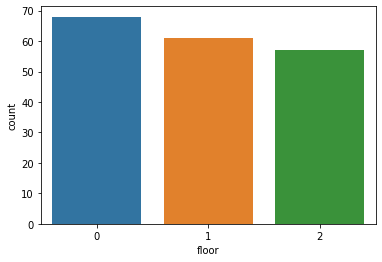

In [ ]:
# number of samples per floor
sns.countplot(dataset.floor)

In [ ]:
# List of buildings
buildings = dataset.building.unique()
buildings

array(['VM09', 'HS04', 'EC11', 'FV13_B', 'FV14', 'EC08B', 'EC07A', 'CB02',
       'FV13', 'CB09', 'VM02', 'EC07-B', 'HS20', 'CB05S01', 'FV12',
       'TIS06', 'CB03', 'VM06', 'CB01', 'FV11', 'VM04', 'EC10', 'VM03',
       'FV02', 'FV06', 'EC02', 'CB04', 'FV03B', 'CB06'], dtype=object)

In [ ]:
# d = dataset.drop_duplicates(['building','floor']).reset_index(drop=True)[['building','floor']]

## sample audio

In [ ]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)
print(sampled.samples.values[0])
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 48000
Shape: (1, 240000)
Dtype: torch.float32
 - Max:      0.256
 - Min:     -0.231
 - Mean:    -0.000
 - Std Dev:  0.053

tensor([[-0.0455, -0.0493, -0.0505,  ...,  0.0460,  0.0499,  0.0544]])

R+1/VM06_1/Esquissons_VM06_1.wav_4.wav


Etage  1


In [ ]:
# path=os.path.join("/content","Data","R+1","CB01_2","Esquissons_CB01_2.wav")
# waveform,sample_rate = torchaudio.load(path,format="wav")
# play_audio(waveform,sample_rate)

In [ ]:
dataset

,samples,floor,building
0,R+3/VM09/Esquissons_VM09.wav_0.wav,1,VM09
1,R+1/HS04/Esquissons_HS04.wav_1.wav,0,HS04
2,R+3/EC11/Esquissons_EC11.wav_4.wav,1,EC11
3,R+5/FV13_B_1/Esquissons_FV13B_1.wav_2.wav,2,FV13_B
4,R+5/FV14/Esquissons_FV14 wave.wav_2.wav,2,FV14
...,...,...,...
181,R+5/TIS06/Esquissons_TIS06.wav_1.wav,2,TIS06
182,R+3/EC10_1/Esquissons_EC10_1.wav_2.wav,1,EC10
183,R+1/CB04_2/Esquissons_CB04_2.wav_2.wav,0,CB04
184,R+1/EC02/Esquissons_EC02.wav_4.wav,0,EC02


In [ ]:
dataset.building.nunique()#==68+61+57

29

## Modalities experimentations

### Raw

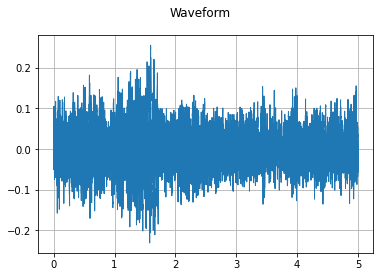

In [ ]:
# plot raw waveform

plot_waveform(waveform,sample_rate=sample_rate)

In [ ]:
waveform.shape

torch.Size([1, 240000])

In [ ]:
random.uniform(0.85,1.15)

1.0418280395373651

In [ ]:
random.choice([1.1,1.2])

1.1

In [ ]:

effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", str(random.choice([0.85,0.9,0.95,1.15,1.05]))],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ['gain', '-n', str(random.choice([-10,-5,0,5,10]))],  # apply 10 db attenuation

    ["rate", f"{sample_rate}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)


In [ ]:
play_audio(waveform2,sample_rate2)

### FOURRIER

### Spectrogram

Shape: (1, 513, 469)
Dtype: torch.float32
 - Max:     5151.325
 - Min:      0.000
 - Mean:     1.280
 - Std Dev: 30.153

tensor([[[1.1878e+02, 3.5138e+01, 7.5433e+01,  ..., 2.2445e+02,
          1.2090e+02, 6.1893e+00],
         [4.3466e+00, 1.8501e+02, 3.0646e+01,  ..., 2.7819e+02,
          7.8634e+01, 2.9250e+01],
         [2.8378e-02, 1.1953e+02, 1.5475e+00,  ..., 1.4387e+02,
          1.2044e+01, 5.6347e+01],
         ...,
         [3.8817e-06, 3.9637e-07, 8.7536e-07,  ..., 1.7686e-06,
          5.8250e-06, 5.6725e-08],
         [3.2932e-06, 1.4014e-06, 7.3770e-08,  ..., 8.7738e-05,
          6.6136e-06, 1.0025e-06],
         [2.5487e-06, 2.0614e-06, 1.1531e-06,  ..., 2.3841e-04,
          1.2875e-05, 8.8130e-07]]])



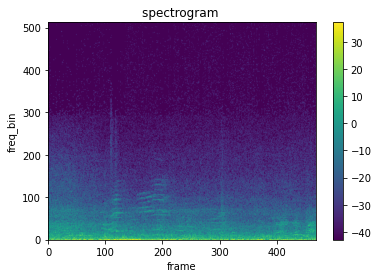

In [ ]:
n_fft = 1024
win_length = 1024
hop_length = None

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=False,
)

# define transformation
spectrogram_norm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True,
)
# Perform transformation
spec1 = spectrogram(waveform)
# Perform transformation
spec2 = spectrogram_norm(waveform)


print_stats(spec1)
#print_stats(spec2)
plot_spectrogram(spec1[0], title='spectrogram ')
#plot_spectrogram(spec2[0], title='spectrogram normalized')

In [ ]:
spec1.shape

torch.Size([1, 513, 469])

In [ ]:
spec1[0].max()

tensor(5151.3247)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

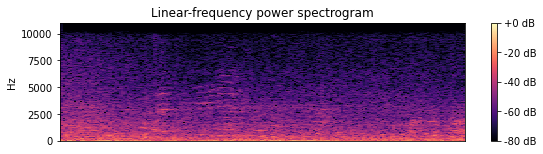

In [ ]:
# obtaining spectrogram using librosa
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

### MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape: (1, 256, 469)
Dtype: torch.float32
 - Max:     242.767
 - Min:     -218.944
 - Mean:    -2.453
 - Std Dev: 18.160

tensor([[[-1.4713e+02, -1.3896e+02, -1.4312e+02,  ..., -1.5657e+02,
          -1.7299e+02, -1.7973e+02],
         [ 2.1208e+02,  2.1722e+02,  1.9624e+02,  ...,  2.1756e+02,
           2.1316e+02,  2.2112e+02],
         [-6.5755e+01, -6.5994e+01, -6.7103e+01,  ..., -6.5504e-01,
          -1.2450e+01, -2.1247e+01],
         ...,
         [ 3.6015e+00,  4.3363e+00,  5.3935e+00,  ...,  3.6280e+00,
           3.6569e+00,  5.5749e+00],
         [ 8.3434e-01,  2.3190e+00, -1.5173e-02,  ...,  2.8609e+00,
           3.3932e+00,  9.7023e-01],
         [-1.5610e+00,  6.8373e-01,  3.6094e-01,  ..., -2.2964e-01,
           3.7920e+00,  1.6825e+00]]])



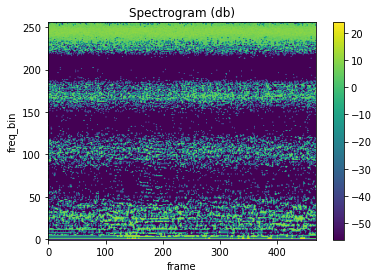

In [ ]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

# Preprocessing & Packaging

check 
* https://jonathanbgn.com/2021/08/30/audio-augmentation.html
* https://developers.deepgram.com/blog/2022/06/pytorch-intro-with-torchaudio/

## Waveform

In [ ]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList,transform = False):
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        self.transform = transform
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i,1])
                #self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + self.file_names[index]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        sound ,sample_rate = torchaudio.load(path, normalize = True)
        #print(sound.shape)
        # apply some effects : https://pytorch.org/tutorials//beginner/audio_data_augmentation_tutorial.html
        # if self.transform:
        #   effects = [
        #       #["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        #       ["speed", str(random.choice([0.95,1,1.05]))],  # reduce the speed
        #       # This only changes sample rate, so it is necessary to
        #       # add `rate` effect with original sample rate after this.
        #       ['gain', '-n', str(random.choice([-5,-2.5,0,2.5,5]))],  # apply 10 db attenuation

        #       ["rate", f"{sample_rate}"],
        #       #["reverb", "-w"],  # Reverbration gives some dramatic feeling
        #   ]
        #   # # Apply effects
        #   sound, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(sound, sample_rate, effects)
        #   #print(sound.shape)
        sound = torch.mean(sound, dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        soundData = sound
        #print(soundData.shape,soundData.numel())
        #downsample the audio to ~8kHz
        # 120000
        tempData = torch.zeros([200000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 200000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:200000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([40000, 1])
        #chunk = random.randint(0,4)
        soundFormatted[:40000] = soundData[::5]#take every sixth sample of soundData
        #soundFormatted = soundFormatted[chunk*40000:(chunk+1)*40000] #take a random chunk
        soundFormatted = soundFormatted.permute(1, 0)

        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


## Spectrogram

In [ ]:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# check also https://colab.research.google.com/github/enzokro/clck10/blob/master/_notebooks/2020-09-10-Normalizing-spectrograms-for-deep-learning.ipynb#scrollTo=VBD562J9i2AF
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled


def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - 1.15) / (27 + eps)
  #spec_min, spec_max = spec_norm.min(), spec_norm.max()
  #spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_norm

In [ ]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_fft, normalized=False, win_length = None, center = True,transform = False, pad_mode = "reflect", power = 2.0,hop_length=None):
        super().__init__(csvData, file_path, folderList,transform)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        self._normalized = normalized
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
          normalized=self._normalized,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      transformed = self._spec_mixer(soundFormatted)
      # apply transformation
      return transformed, labels

    
    def __len__(self):
        return len(self.file_names)

## MFCC

In [ ]:
# NORMALIZE VALUES
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk',hop_length=512):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        #print("ok",win_length)
        #self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,
              #'win_length':self._n_fft,
            },
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

## Late fusion

In [ ]:
# NORMALIZE VALUES
class ComposedDataset(MFCCSoundDataset,SpecSoundDataset):    
    def __init__(self, datasets):
        assert(len(datasets)>0),"You should provide at least one dataset"
        assert(len(datasets[0])>0),"Datasets must not be empty"
        assert(all(len(datasets[0])==len(d) for d in datasets)),"All datasets don't have same size"
        self.datasets = datasets

    def __getitem__(self, index):
      tmp = [dataset[index] for dataset in self.datasets]
      labels = tmp[0][1]
      return torch.cat([reshaper(t[0]) for t in tmp]),labels
    
    def __len__(self):
        return len(self.datasets[0])

## Splitting Scheme

To prevent overfitting from look alike samples from same building, train test and dev splitting is done per building.

In [ ]:
os.chdir("/content/")

In [ ]:
csv_path = './building_floor_recognition.csv'
file_path = './Data/'

In [ ]:
# DEPRECATED
# X_train, X_test = train_test_split(dataset, test_size=0.2, stratify = dataset.floor)
# X_train, X_val = train_test_split(X_train, test_size=0.2, stratify = X_train.floor)

In [ ]:
# Testing scheme assuring that no building is in train and test set

test_dataset_ = dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(2)).reset_index(drop=True)[['building','floor']]
test_dataset = pd.merge(dataset,test_dataset_, on = ['building','floor'])
test_dataset.head()
new_dataset = pd.concat([dataset,test_dataset]).drop_duplicates(keep=False)
val_dataset_ = new_dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(1)).reset_index(drop=True)[['building','floor']]
val_dataset = pd.merge(dataset,val_dataset_, on = ['building','floor'])
val_dataset.head()
final_dataset = pd.concat([new_dataset,val_dataset]).drop_duplicates(keep=False)
final_dataset.shape
assert(len(final_dataset)+len(val_dataset)+len(test_dataset)==len(dataset)),"You did something wrong"

In [ ]:
X_train_samples = final_dataset
X_train_samples =  X_train_samples.drop(X_train_samples.index[[100,38,111,117,105]]).reset_index(drop=True)
X_val_samples = val_dataset
X_test_samples = test_dataset

In [ ]:
print("All set size: " + str(len(dataset)))
print("Train set size: " + str(len(X_train_samples)))
print("Val set size: " + str(len(X_val_samples)))
print("Test set size: " + str(len(X_test_samples)))


All set size: 186
Train set size: 122
Val set size: 14
Test set size: 45


In [ ]:
# # configure MFCC settings 
# config_spec_args = {
#     'n_fft':512,
#     'n_mfcc':180,
#     'sample_rate':8000,
#     'n_mels':180,

# }

# train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_spec_args)
# test_set = MFCCSoundDataset(X_test, file_path, [10], **config_spec_args)

# Models

In [ ]:

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        latent_dim = 64
        #Encoder
        self.conv1 = nn.Conv2d(2, 8, 3, padding=2)  
        self.conv2 = nn.Conv2d(8, 1, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(1, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 2, 2, stride=2)


        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_log_var = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc1 = nn.Linear(64,latent_dim)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def encoder(self,x):
      x = self.relu(self.conv1(x))
      x = self.pool(x)
      x = self.relu(self.conv2(x))
      x = self.pool(x)
      return x

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # sampling & reparametrization 
        x = self.fc1(x)
        # get `mu` and `log_var`
        # mu = self.fc_mu(x)
        # log_var = self.fc_log_var(x)
        # # get the latent vector through reparameterization
        # z = self.reparameterize(mu, log_var)
        # x = self.fc2(z)
        
        x = self.relu(self.t_conv1(x))
        x = self.relu(self.t_conv2(x))
              
        return x

# Training & Evaluation

## utils

In [ ]:
# Reporting strategies

class NoneReporter:
  """
    proxy used for any reporter ( wandb, tensorboard, etc)
  """
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    pass

  def stop(self):
    pass
  def start(self,**kwargs):
    pass

class WandbReporter(NoneReporter):
  """
    wand reporter with permanent storage and wandb dashboard
  """
  def __init__(self,wandb,**kwargs):
    super().__init__()
    self._wandb = wandb
    self._kwargs = kwargs
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(data)

  def stop(self):
    self._wandb.finish()

  def start(self,**kwargs):
    self._wandb.init(project="audio-classification",**self._kwargs)#,settings=wandb.Settings(start_method="thread")
    


class DummyReporter(NoneReporter):
  """
    quick reporter with non permanent storage
  """
  def __init__(self):
    self._data={}

  def log(self,data:Dict[str, Any]):
    for key in data.keys():
      if key in self._data:
        self._data[key].append(data[key])
      else:
        self._data[key]=[data[key]]

  def get(self,key):
    return self._data[key]

  def stop(self):
    pass

  def start(self,**kwargs):
    pass

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [ ]:
# Function to save the model
def saveModel(model,loss,base_path,suffix):
    path = f"bestModel_{suffix}.pth"
    if base_path:
      path = os.path.join(base_path,path)

    torch.save(model.state_dict(), path)

    return path

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
from sklearn.metrics import accuracy_score

def evaluate(model_to_evaluate,evaluation_loader,loss_fn,device=torch.device("cpu")):
    model_to_evaluate.eval()
    for m in model_to_evaluate.modules():
      for child in m.children():
          if type(child) == nn.BatchNorm2d:
              child.track_running_stats = False
    # for m in model_to_evaluate.modules():
    #     if isinstance(m, nn.BatchNorm2d):
    #       m.track_running_stats=False
    model_to_evaluate.to(device)
    loss = 0.0
    y_true =[]
    y_pred = []
    res = []
    with torch.no_grad():
        for images, labels in evaluation_loader:
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model_to_evaluate(images)
          
            #print(outputs.data)
            l = loss_fn(outputs, labels)
            loss += l #* labels.size(0)
            res.append(l)
            
            # the label with the highest energy will be our prediction
            
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
    accuracy = accuracy_score(y_true,y_pred)*100
    #print(res)
    #print(loss.item()/len(evaluation_loader))

    #print("------------------------------------------------")
    #input()
    return (loss.item()/len(evaluation_loader), accuracy)

In [ ]:
# wandb.finish()

In [ ]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,train_steps=1000,device=torch.device("cpu"),reporter = None):
    
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    
    running_loss = 0.0
    running_acc = 0.0
    running_samples = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        
        model.train()
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))


        # predict classes using images from the training set
        outputs = model(images)
        # print(outputs.data)
        # print("labels=",labels)
        # compute the loss based on model output and real labels
        loss = loss_fn(outputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        #loss = F.nll_loss(outputs.squeeze(), labels)
        
        # backpropagate the loss
        loss.backward()

        # # https://discuss.pytorch.org/t/how-to-check-for-vanishing-exploding-gradients/9019
        # for name, param in model.named_parameters():
        #  print(name, param.grad.norm())
        #adjust parameters based on the calculated gradients
        optimizer.step()

        # Let's print statistics for every 1,000 images
        running_loss = loss.item()    # extract the loss value
        #running_samples += labels.size(0)
        # print(running_samples)
      #if i % (train_steps) == (train_steps-1):    
      # print every 1000 (twice per epoch) 
        #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
        
        reporter.log({'train_loss':running_loss })
          # zero the loss
        #return running_loss

        

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_classification_stats(model, loader,n_classes, device, classes=None):
  y_pred = []
  y_true = []

  model.eval()
  model.to(device)
  # iterate over test data
  for inputs, labels in loader:
          inputs,labels = inputs.to(device),labels.to(device)
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  if classes == None:
    classes = list(map(str,range(n_classes)))
  print(classification_report(y_true, y_pred, target_names=classes))
  


In [ ]:
def initialize_weights(m):
   # look at : https://androidkt.com/initialize-weight-bias-pytorch/
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
# define a cross validation function
def leaveoneout(model=None,criterion=None,dataset=None,k_fold=5,device=torch.device("cpu"),num_epochs=1, train_steps=1,lr=3e-4):
    config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
      'normalized':True,
    }
    train_score = pd.Series()
    val_score = pd.Series()
    grouped = dataset.drop_duplicates(['building']).groupby('floor')
    print(grouped)
    res = []
    for i in range(len(grouped)):
        val_dataset_ = grouped.apply(lambda x:x.sample(1)).reset_index(drop=True)[['building','floor']]
        val_dataset = pd.merge(dataset,val_dataset_, on = ['building','floor'])
        
        final_dataset = pd.concat([new_dataset,val_dataset]).drop_duplicates(keep=False)
        print(f"Fold {i+1} training")
        _train_loader = SpecSoundDataset(final_dataset, file_path, range(0,6),transform = False, **config_spec_args)
        _val_loader = SpecSoundDataset(val_dataset, file_path, range(0,6), **config_spec_args)
        
        res_model = deepcopy(model)
        _optimizer = torch.optim.Adam(res_model.parameters(), lr=lr)
        train(res_model,_train_loader,_optimizer,criterion, train_steps=train_steps,device=device)
        train_score.at[i] = l, val_acc = evaluate(res_model,_train_loader,criterion,device)
        l, val_acc = evaluate(res_model,_val_loader,criterion,device)
        val_score.at[i] = val_acc
        #res.append((train))
        del res_model
    plot_classification_stats(loaded_model,DATA[modality]['test_loader'],device)


In [ ]:
dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x:x.sample(1))

,,samples,floor,building
floor,,,,
0,13,R+1/EC07-B/Esquissons_EC07B.wav_4.wav,0,EC07-B
1,2,R+3/EC11/Esquissons_EC11.wav_4.wav,1,EC11
2,73,R+5/CB06/Esquissons_CB6S01 wave.wav_0.wav,2,CB06


In [ ]:
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
test_model = NotSimpleNet(in_channels=1,n_output=3,repr_size=512)


In [ ]:
loss_fn = nn.CrossEntropyLoss()


In [ ]:
#leaveoneout(model=test_model,criterion=loss_fn,dataset=dataset,device=torch.device("cpu"),num_epochs=1, train_steps=1,lr=3e-4)


check out https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc

## Dataset Creation

In [ ]:
DATA ={}
batch_size = 8

In [ ]:

# configure spectrogram settings 
config_spec_args = {
    'n_fft':1024,
    'win_length':256,
}
all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
train_set_spec = SpecSoundDataset(X_train_samples, file_path, range(0,6),transform = False, **config_spec_args)
val_set_spec = SpecSoundDataset(X_val_samples, file_path, range(0,6), **config_spec_args)
test_set_spec = SpecSoundDataset(X_test_samples, file_path, range(0,6), **config_spec_args)
n_classes = X_train_samples.floor.nunique()
print("All set size: " + str(len(all_set)))
print("Train set size: " + str(len(train_set_spec)))
print("Val set size: " + str(len(val_set_spec)))
print("Test set size: " + str(len(test_set_spec)))



kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set_spec, batch_size = batch_size , shuffle = False, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set_spec, batch_size = batch_size , shuffle = False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set_spec, batch_size = batch_size, shuffle = False, **kwargs)
DATA['spec']={}
DATA['spec']['train_set']=train_set_spec
DATA['spec']['val_set']=val_set_spec
DATA['spec']['test_set']=test_set_spec
DATA['spec']['train_loader']=train_loader
DATA['spec']['val_loader']=val_loader
DATA['spec']['test_loader']=test_loader


All set size: 186
Train set size: 122
Val set size: 14
Test set size: 45


In [ ]:


# configure spectrogram settings 
config_spec_args = {
    'n_fft':1024,
    'win_length':256,
    'normalized':True,
}
all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
train_set = SpecSoundDataset(X_train_samples, file_path, range(0,6),transform = False, **config_spec_args)
val_set = SpecSoundDataset(X_val_samples, file_path, range(0,6), **config_spec_args)
test_set = SpecSoundDataset(X_test_samples, file_path, range(0,6), **config_spec_args)
n_classes = X_train_samples.floor.nunique()
print("All set size: " + str(len(all_set)))
print("Train set size: " + str(len(train_set)))
print("Val set size: " + str(len(val_set)))
print("Test set size: " + str(len(test_set)))



kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = False, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, **kwargs)
DATA['spec_norm']={}
DATA['spec_norm']['test_set']=test_set
DATA['spec_norm']['train_set']=train_set
DATA['spec_norm']['val_set']=val_set
DATA['spec_norm']['train_loader']=train_loader
DATA['spec_norm']['val_loader']=val_loader
DATA['spec_norm']['test_loader']=test_loader


All set size: 186
Train set size: 122
Val set size: 14
Test set size: 45


In [ ]:
val_set[2][0][0].shape

torch.Size([513, 313])

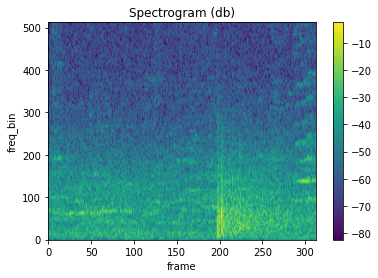

In [ ]:
 a = plot_spectrogram(val_set[5][0][0]) # first index 

In [ ]:
# configure spectrogram settings 
config_mel_args ={
              'n_fft':1024,
            'n_mfcc': 1024,
            'n_mels': 1024,
            'sample_rate':8820,
            #'hop_length':512,
}
all_set = MFCCSoundDataset(dataset, file_path, range(0,6),**config_mel_args)
train_set = MFCCSoundDataset(X_train_samples, file_path, range(0,6), **config_mel_args)
val_set = MFCCSoundDataset(X_val_samples, file_path, range(0,6), **config_mel_args)
test_set = MFCCSoundDataset(X_test_samples, file_path, range(0,6), **config_mel_args)
n_classes = X_train_samples.floor.nunique()
print("All set size: " + str(len(all_set)))
print("Train set size: " + str(len(train_set)))
print("Val set size: " + str(len(val_set)))
print("Test set size: " + str(len(test_set)))



kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
DATA['mfcc']={}
DATA['mfcc']['test_set']=test_set
DATA['mfcc']['train_set']=train_set
DATA['mfcc']['val_set']=val_set
DATA['mfcc']['train_loader']=train_loader
DATA['mfcc']['val_loader']=val_loader
DATA['mfcc']['test_loader']=test_loader


All set size: 186
Train set size: 122
Val set size: 14
Test set size: 45


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


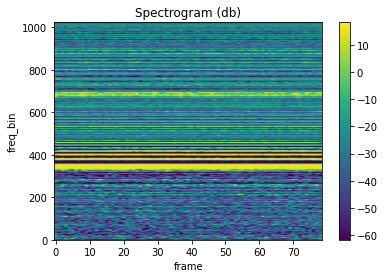

In [ ]:
a = plot_spectrogram(val_set[2][0][0]) # first index 

In [ ]:
val_set[2][0][0].shape

torch.Size([1024, 79])

In [ ]:
train_set = ComposedDataset([DATA['spec']['train_set'],DATA['mfcc']['train_set']])
val_set = ComposedDataset([DATA['spec']['val_set'],DATA['mfcc']['val_set']])
test_set = ComposedDataset([DATA['spec']['test_set'],DATA['mfcc']['test_set']])
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = False, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, **kwargs)
DATA['composed']={}
DATA['composed']['train_set']=train_set
DATA['composed']['val_set']=val_set
DATA['composed']['test_set']=test_set
DATA['composed']['train_loader']=train_loader
DATA['composed']['val_loader']=val_loader
DATA['composed']['test_loader']=test_loader

## Early Fusion : Training & Evaluation

In [ ]:
train_set[0][0].shape

torch.Size([2, 256, 256])

In [ ]:
model = ConvAutoencoder()

In [ ]:
model.to(device)(reshaper(next(iter(DATA['composed']['train_loader']))[0][0].to(device)))

tensor([[[0.0000, 0.0766, 0.3774,  ..., 0.0287, 0.6216, 0.0000],
         [0.0000, 0.0000, 0.1291,  ..., 0.0000, 0.0707, 0.3139],
         [0.1170, 0.0000, 0.0943,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0879, 0.1017, 0.1224,  ..., 0.0609, 0.1457, 0.1549],
         [0.1824, 0.0861, 0.1882,  ..., 0.0617, 0.1847, 0.0319],
         [0.1061, 0.1057, 0.1088,  ..., 0.0775, 0.1068, 0.1159]],

        [[0.2064, 0.0000, 0.0000,  ..., 0.0000, 0.0094, 0.0023],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6245],
         [0.0000, 0.0872, 0.0000,  ..., 0.2598, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#Epochs
n_epochs = 300
model.to(device)
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in DATA['composed']['train_loader']:
        images, _ = data
        images = reshaper(images)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 1375.071611
Epoch: 2 	Training Loss: 1366.356195
Epoch: 3 	Training Loss: 1349.112209
Epoch: 4 	Training Loss: 1323.584398
Epoch: 5 	Training Loss: 1293.961304
Epoch: 6 	Training Loss: 1267.131985
Epoch: 7 	Training Loss: 1251.848011
Epoch: 8 	Training Loss: 1245.289024
Epoch: 9 	Training Loss: 1240.386665
Epoch: 10 	Training Loss: 1236.727821
Epoch: 11 	Training Loss: 1233.805643
Epoch: 12 	Training Loss: 1231.693037
Epoch: 13 	Training Loss: 1230.222452
Epoch: 14 	Training Loss: 1227.389931
Epoch: 15 	Training Loss: 1225.718864
Epoch: 16 	Training Loss: 1224.952747
Epoch: 17 	Training Loss: 1224.426273
Epoch: 18 	Training Loss: 1223.991539
Epoch: 19 	Training Loss: 1223.612566
Epoch: 20 	Training Loss: 1223.297947
Epoch: 21 	Training Loss: 1223.014261
Epoch: 22 	Training Loss: 1222.752192
Epoch: 23 	Training Loss: 1222.516211
Epoch: 24 	Training Loss: 1222.302013
Epoch: 25 	Training Loss: 1222.103640
Epoch: 26 	Training Loss: 1221.920456
Epoch: 27 	Training L

In [ ]:
DATA['composed']['train_set'][0][0].shape

torch.Size([1, 513, 313])

In [ ]:
X_train,y_train = tuple(zip(*[(model.to('cpu').encoder(spec).flatten().detach().numpy(),y) for (spec,y) in DATA['composed']['train_set']]))
X_val,y_val = tuple(zip(*[(model.to('cpu').encoder(spec).flatten().detach().numpy(),y) for (spec,y) in DATA['composed']['val_set']]))
X_test,y_test = tuple(zip(*[(model.to('cpu').encoder(spec).flatten().detach().numpy(),y) for (spec,y) in DATA['composed']['test_set']]))

In [ ]:
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure


from sklearn.decomposition import PCA
pca = PCA(n_components=3)


x = StandardScaler().fit_transform(X_train)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2','pca3'])

principalDf



,pca1,pca2,pca3
0,-0.720421,1.290903,-8.894057
1,-50.526456,-1.193271,3.326198
2,-42.574234,2.356498,12.961352
3,-34.183472,0.401264,2.510951
4,-8.755917,-2.657198,-9.286398
...,...,...,...
117,-23.469029,-3.257646,6.236161
118,-80.847403,8.701163,-1.823477
119,-11.161644,-7.313634,-7.399700
120,54.219729,-8.623257,-8.509558


<Figure size 1584x1440 with 0 Axes>

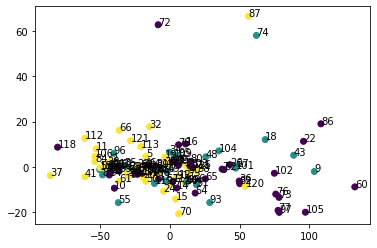

In [ ]:
plt.figure(figsize=(22,20))

fig, ax = plt.subplots()
ax.scatter(principalDf['pca1'], principalDf['pca2'], c=y_train)



for i, txt in enumerate(y_train):
    ax.annotate(i, (principalDf['pca1'][i], principalDf['pca2'][i]))
plt.show()

In [ ]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",X_train_samples.iloc[72].samples)
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)
print(SAMPLE_WAV_PATH)
play_audio(waveform,sample_rate)
#print("Etage ",sampled.floor.values[0])

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 48000
Shape: (1, 240000)
Dtype: torch.float32
 - Max:      0.054
 - Min:     -0.059
 - Mean:     0.000
 - Std Dev:  0.009

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0186, 0.0170, 0.0161]])

/content/Data/R+1/CB09_2/Esquissons_CB09_2.wav_0.wav


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


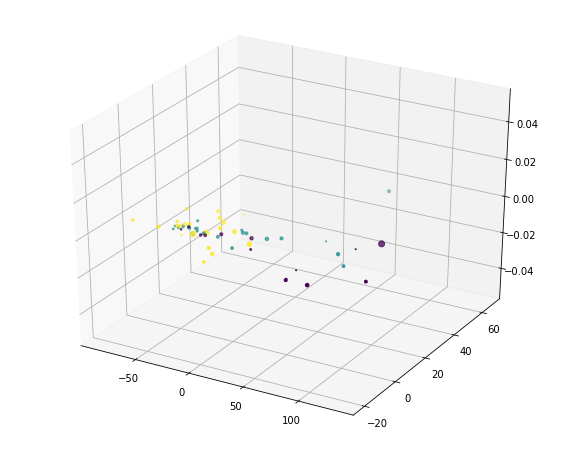

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.add_subplot(projection='3d')
plt.scatter(principalDf['pca1'], principalDf['pca2'],principalDf['pca3'], c=y_train)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train,y_train)

1.0

In [ ]:
clf.score(X_val,y_val)

0.35714285714285715

In [ ]:
clf.score(X_test,y_test)

0.4888888888888889

In [ ]:
X_train[0]

array([21.636957 , 23.754257 , 24.039282 , ...,  2.2472203,  2.1716166,
        1.9345297], dtype=float32)

# Results